# IBM Coursera Project - The_Battle_of_Neighborhoods

## Table of contents

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>

Have some venture capital and would like to open a **restaurant** in the **Chicago** area?

Have troubles finding **where** to open the restaurant and **what** restaurant to open?

Will your restaurant **get popular** or will it be **cannibalized**?

The aim of this project is to help people who want to open a restaurant in the Chicago area find an **ideal restaurant location** and **profitable restaurant type**. The project will utilize **foursquare API** to collect necessary information for this analysis.

First, we will use geopy to get Chicago's latitude and longitude. 

Then we will find the top 30 venues in the Chicago area, since we would like open our restaurant in a popular place with enough human traffic. 

Third, we will collect restaurant information within each venue, cluster each venue based on its restaurant category information. 

Finally, we will plot the clustering information on the map and conduct some qualitative assesments.

# Data <a name="data"></a>

We will only use foursqure API to get the specific inforamtion of Chicago's top venues and its nearby restaurants:

* Venues' latitudes and longitudes
* Restaurants' latitudes, longitudes, type and ratings
* Nominatim's goole

In [1]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup as bs
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import requests
from geopy.geocoders import Nominatim
from datetime import date
import matplotlib.pyplot as plyt
import seaborn as sns
from geopy.geocoders import Nominatim
%matplotlib inline

In [2]:
login = pd.read_csv(r'C:\Users\paulf\OneDrive\Desktop\foursquare.csv')
v = date.today().strftime('%Y%m%d')

geolocator = Nominatim(user_agent = 'google')
geocodes = geolocator.geocode('Chicago, USA')
map_lat = geocodes.latitude
map_lng = geocodes.longitude

# Methodology <a name="methodology"></a>

* [First, we use foursquare API to find the top 30 venues in the Chicago area and extract their latitudes and longitudes information.](#step1)
* [Second, we find the top 30 restaurants within 500 miles radius of each venue location and store their information.](#step2)
* [Third, we use one-hot encoding and GridSearchCV to find the best parameters for KMeans and cluster all the venues.](#step3)
* [Fourth, we determine the top 3 restaurant types for each cluster label and highlight them in the pivot tables.](#step4)


### Step 1: Find the top 30 venues in the Chicago area <a name="step1"></a>

In [3]:
venue = requests.get('https://foursquare.com/explore?mode=url&near=Chicago%2C%20IL%2C%20United%20States&nearGeoId=72057594043056517&q=Top%20Picks')
soup = bs(venue.content, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/">
 <head>
  <title>
   Top Picks New York, NY
  </title>
  <meta content="en" http-equiv="Content-Language"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="Foursquare" name="application-name"/>
  <meta content="#0ca9c9" name="msapplication-TileColor"/>
  <meta content="https://playfoursquare.s3.amazonaws.com/misc/foursquare-144-logo.png" name="msapplication-TileImage"/>
  <meta content="Start the foursquare App" name="msapplication-tooltip"/>
  <meta content="/" name="msapplication-starturl"/>
  <meta content="width=1024;height=768" name="msapplication-window"/>
  <meta content="name=Recent Check-ins; action-uri=/; icon-uri=/favicon.ico" name="msapplication-task"/>
  <meta content="name=Profile;action-uri=/user;icon-uri=/favicon.ico" name="msapplication-task"/>
  <meta content="name=His

In [4]:
venue_list = soup.find('div', id = 'results').find_all('li')
column_name = ['venue_name', 'venue_id', 'venue_score', 'venue_address', 'venue_lat', 'venue_lng']
venue_col = pd.DataFrame(columns = column_name)
venue_name = []
venue_id = []
venue_score=[]
venue_address =[]
venue_lat = []
venue_lng = []

for venue in venue_list:
    try:
        if venue.attrs.get('data-id') != None:
            venue_id.append(venue.attrs.get('data-id'))
            venue_name.append(venue.find('div', class_ = 'venueName').a.get_text())
            venue_score.append(venue.find('div', class_ = 'venueScore positive').get_text())
            venue_address.append(venue.find('div', class_ = 'venueAddress').get_text())
    except:
        continue

venue_col['venue_name'] = venue_name
venue_col['venue_id'] = venue_id
venue_col['venue_score'] = venue_score
venue_col['venue_address'] = venue_address

for index, row in venue_col.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row[1], 
                                                                                              login.iloc[0,0], login.iloc[0,1],v)
    result = requests.get(url).json()
    venue_lat.append(result['response']['venue']['location']['lat'])
    venue_lng.append(result['response']['venue']['location']['lng'])

venue_col['venue_lat'] = venue_lat
venue_col['venue_lng'] = venue_lng
venue_col.head()

KeyError: 'venue'

### Step2 : Find nearby restaurants for each venue <a name="step2"></a>

In [87]:
restaurant_column = ['venue_id', 'food_name', 'food_cat', 'food_lat', 'food_lng']
categoryId = '4d4b7105d754a06374d81259'
radius = 500
limit = 30
restaurant_col = pd.DataFrame(columns = restaurant_column)

In [88]:
for index, row in venue_col.iterrows():
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
            login.iloc[0,0], login.iloc[0,1], row[4], row[5], v, categoryId, radius, limit)
    result = requests.get(url).json()['response']
    for food in result['venues']:
        restaurant_col = restaurant_col.append({'venue_id': row[1], 'food_name': food['name'],
                                                'food_cat': food['categories'][0]['name'],
                                                'food_lat': food['location']['lat'],
                                                'food_lng': food['location']['lng']}, ignore_index = True)


restaurant_col = restaurant_col.merge(venue_col, how = 'inner', left_on = 'venue_id', right_on = 'venue_id')
restaurant_col.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng
0,412d2800f964a520df0c1fe3,American Wing Cafe,Café,40.780246,-73.963507,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
1,412d2800f964a520df0c1fe3,Starbucks Reserve,Coffee Shop,40.779850,-73.959584,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
2,412d2800f964a520df0c1fe3,Starbucks,Coffee Shop,40.780136,-73.959564,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
3,412d2800f964a520df0c1fe3,Herm's Box Food Truck,Food Truck,40.787367,-73.967607,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
4,412d2800f964a520df0c1fe3,Gentiles,Deli / Bodega,40.779118,-73.960062,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853


In [89]:
restaurant_col['venue_score'] = restaurant_col['venue_score'].apply(lambda x: float(x))
restaurant_col.dtypes

venue_id          object
food_name         object
food_cat          object
food_lat         float64
food_lng         float64
venue_name        object
venue_score      float64
venue_address     object
venue_lat        float64
venue_lng        float64
dtype: object

In [14]:
### restaurant_col.to_csv(r'C:\Users\paulf\OneDrive\Desktop\restaurant_col.csv') 

In [6]:
### restaurant_col = pd.read_csv(r'C:\Users\paulf\OneDrive\Desktop\restaurant_col.csv', index_col = 0)
### restaurant_col.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng
0,412d2800f964a520df0c1fe3,American Wing Cafe,Café,40.780246,40.780246,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
1,412d2800f964a520df0c1fe3,Herm's Box Food Truck,Food Truck,40.787367,40.787367,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
2,412d2800f964a520df0c1fe3,Starbucks,Coffee Shop,40.780136,40.780136,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
3,412d2800f964a520df0c1fe3,Café Sabarsky,Austrian Restaurant,40.781445,40.781445,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
4,412d2800f964a520df0c1fe3,Starbucks Reserve,Coffee Shop,40.779850,40.779850,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853


### Step 3: Use KMeans and GridSearchCV to cluster venues based on restaurant type <a name="step3"></a>

In [90]:
restaurant_pivot = restaurant_col.pivot_table(values = ['food_name'], index = ['venue_name'], columns = ['food_cat'],
                           aggfunc = lambda x: len(x), fill_value = 0).apply(lambda x: x/x.sum(), axis = 1)
new_column = restaurant_pivot.columns.droplevel(0)
restaurant_pivot.columns = new_column
restaurant_pivot.index.name = None
restaurant_pivot.columns.name = None
restaurant_pivot.head()

,American Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Garden,Bistro,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
Aire Ancient Baths,0.166667,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
Astor Wines & Spirits,0.033333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.033333,0.0
Battery Park City Esplanade,0.000000,0.0,0.0,0.0,0.033333,0.0,0.033333,0.000000,0.033333,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
Bethesda Fountain,0.074074,0.0,0.0,0.0,0.000000,0.0,0.074074,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
Brooklyn Bridge,0.100000,0.0,0.0,0.0,0.000000,0.0,0.066667,0.066667,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [91]:
param_var = [{'n_clusters': np.arange(5,12), 'n_init': np.arange(5,16), 'max_iter': np.linspace(100, 500, 9)}]
search_cv = GridSearchCV(KMeans(random_state = 1), param_var).fit(restaurant_pivot)
best_params = search_cv.best_params_

D:\Work\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Work\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [92]:
kmeans = KMeans(n_clusters = best_params['n_clusters'], n_init = best_params['n_init'], max_iter = best_params['max_iter']).fit(restaurant_pivot)
kmeans.labels_[:5]

array([5, 5, 0, 1, 3])

In [93]:
restaurant_pivot['Label'] = kmeans.labels_.tolist()
restaurant_pivot.reset_index(inplace = True)
restaurant_pivot = restaurant_pivot.iloc[:,[0,-1]]
restaurant_pivot.rename(columns = {'index': 'venue_name'}, inplace = True)
restaurant_pivot.head()

,venue_name,Label
0,Aire Ancient Baths,5
1,Astor Wines & Spirits,5
2,Battery Park City Esplanade,0
3,Bethesda Fountain,1
4,Brooklyn Bridge,3


In [94]:
restaurant_col = restaurant_col.merge(restaurant_pivot, on = 'venue_name')
restaurant_col_group = restaurant_col.groupby('food_cat').count()['food_name'].reset_index()
shuffle = np.arange(restaurant_col_group.shape[0])
np.random.shuffle(shuffle)
restaurant_col_group['color_index'] = shuffle
restaurant_col = restaurant_col.merge(restaurant_col_group[['food_cat', 'color_index']], on = 'food_cat')
restaurant_col_plot = pd.DataFrame(restaurant_col.groupby('venue_name')['venue_score'].mean()).reset_index()
restaurant_col_plot = restaurant_col_plot.merge(restaurant_pivot, on = 'venue_name').pivot_table(index = 'Label', columns = 'venue_name',
                                                                                                values = 'venue_score', fill_value = 0)

In [95]:
restaurant_col.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng,Label,color_index
0,412d2800f964a520df0c1fe3,American Wing Cafe,Café,40.780246,-73.963507,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,1,84
1,412d2800f964a520df0c1fe3,Bluestone Lane,Café,40.783757,-73.958526,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,1,84
2,412d2800f964a520df0c1fe3,Cafe Fledermaus,Café,40.781256,-73.960358,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,1,84
3,412d2800f964a520df0c1fe3,The Petrie Court Cafe & Wine Bar,Café,40.779160,-73.964408,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,1,84
4,412d2800f964a520df0c1fe3,Cafe 3,Café,40.783157,-73.958845,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,1,84


### Step 4: Find the top 3 popular restaurant types for each cluster label <a name="step4"></a>

In [96]:
temp_labels = restaurant_col['Label'].unique()
temp_df = pd.DataFrame(restaurant_col.groupby(['Label', 'food_cat'])['venue_score'].count()).reset_index()
restaurant_top_count = pd.DataFrame()
for label in temp_labels:
    holder_df = temp_df[temp_df['Label'] == label].sort_values(by = 'venue_score', ascending = False).iloc[:10]
    temp_df_pivot = holder_df.pivot_table(values = 'venue_score', index = 'Label', columns = 'food_cat', aggfunc = 'sum', fill_value = 0)
    restaurant_top_count = pd.concat([restaurant_top_count, temp_df_pivot], join = 'outer', axis = 0, sort = False)
restaurant_top_count.fillna(value = 0, inplace = True)
restaurant_top_count.sort_index(inplace = True)
restaurant_top_count

,American Restaurant,Bakery,Café,Coffee Shop,Deli / Bodega,Diner,Food Truck,French Restaurant,Italian Restaurant,New American Restaurant,...,Gastropub,Japanese Restaurant,Chinese Restaurant,Dessert Shop,Dim Sum Restaurant,Dumpling Restaurant,Hotpot Restaurant,Noodle House,Pie Shop,Thai Restaurant
Label,,,,,,,,,,,,,,,,,,,,,
0,13.0,17.0,13.0,62.0,0.0,0.0,0.0,0.0,13.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,7.0,22.0,7.0,8.0,6.0,9.0,6.0,15.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,4.0,2.0,5.0,0.0,0.0,0.0,2.0,8.0,0.0,...,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.0,4.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0
5,21.0,9.0,10.0,71.0,0.0,0.0,0.0,9.0,18.0,9.0,...,0.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
restaurant_top_percentage = restaurant_top_count.apply(lambda x: x/x.sum(), axis = 1 )
restaurant_top_percentage

,American Restaurant,Bakery,Café,Coffee Shop,Deli / Bodega,Diner,Food Truck,French Restaurant,Italian Restaurant,New American Restaurant,...,Gastropub,Japanese Restaurant,Chinese Restaurant,Dessert Shop,Dim Sum Restaurant,Dumpling Restaurant,Hotpot Restaurant,Noodle House,Pie Shop,Thai Restaurant
Label,,,,,,,,,,,,,,,,,,,,,
0,0.077844,0.101796,0.077844,0.371257,0.000000,0.000000,0.000000,0.000000,0.077844,0.047904,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.086957,0.076087,0.239130,0.076087,0.086957,0.065217,0.097826,0.065217,0.163043,0.043478,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.097561,0.097561,0.048780,0.121951,0.000000,0.000000,0.000000,0.048780,0.195122,0.000000,...,0.121951,0.073171,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.155556,0.088889,0.066667,0.133333,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.277778,0.00,0.111111,0.111111,0.111111,0.055556,0.055556,0.055556
5,0.116667,0.050000,0.055556,0.394444,0.000000,0.000000,0.000000,0.050000,0.100000,0.050000,...,0.000000,0.000000,0.050000,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [98]:
def max_yellow(x):
    c = 'background-color: green'
    m = x >= x.nlargest(3).iloc[-1]
    return ['background-color: yellow' if v else '' for v in m]

restaurant_top_count.style.apply(max_yellow, axis = 1)

,American Restaurant,Bakery,Café,Coffee Shop,Deli / Bodega,Diner,Food Truck,French Restaurant,Italian Restaurant,New American Restaurant,Ice Cream Shop,Mexican Restaurant,Pizza Place,Restaurant,Seafood Restaurant,Burger Joint,Fast Food Restaurant,Food Court,Cocktail Bar,Gastropub,Japanese Restaurant,Chinese Restaurant,Dessert Shop,Dim Sum Restaurant,Dumpling Restaurant,Hotpot Restaurant,Noodle House,Pie Shop,Thai Restaurant
Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,13,17,13,62,0,0,0,0,13,8,0,0,0,0,10,16,8,7,0,0,0,0,0,0,0,0,0,0,0
1,8,7,22,7,8,6,9,6,15,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,4,2,5,0,0,0,2,8,0,0,0,4,0,0,0,0,0,4,5,3,0,0,0,0,0,0,0,0
3,7,4,3,6,0,0,0,0,3,0,4,3,6,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,0,0,5,0,2,2,2,1,1,1
5,21,9,10,71,0,0,0,9,18,9,0,0,15,0,0,0,0,0,0,0,0,9,9,0,0,0,0,0,0


In [99]:
restaurant_top_percentage.style.apply(max_yellow, axis = 1)

,American Restaurant,Bakery,Café,Coffee Shop,Deli / Bodega,Diner,Food Truck,French Restaurant,Italian Restaurant,New American Restaurant,Ice Cream Shop,Mexican Restaurant,Pizza Place,Restaurant,Seafood Restaurant,Burger Joint,Fast Food Restaurant,Food Court,Cocktail Bar,Gastropub,Japanese Restaurant,Chinese Restaurant,Dessert Shop,Dim Sum Restaurant,Dumpling Restaurant,Hotpot Restaurant,Noodle House,Pie Shop,Thai Restaurant
Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0778443,0.101796,0.0778443,0.371257,0,0,0,0,0.0778443,0.0479042,0,0,0,0,0.0598802,0.0958084,0.0479042,0.0419162,0,0,0,0,0,0,0,0,0,0,0
1,0.0869565,0.076087,0.23913,0.076087,0.0869565,0.0652174,0.0978261,0.0652174,0.163043,0.0434783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.097561,0.097561,0.0487805,0.121951,0,0,0,0.0487805,0.195122,0,0,0,0.097561,0,0,0,0,0,0.097561,0.121951,0.0731707,0,0,0,0,0,0,0,0
3,0.155556,0.0888889,0.0666667,0.133333,0,0,0,0,0.0666667,0,0.0888889,0.0666667,0.133333,0.111111,0.0888889,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0.0555556,0,0.0555556,0,0,0.111111,0,0,0,0.277778,0,0.111111,0.111111,0.111111,0.0555556,0.0555556,0.0555556
5,0.116667,0.05,0.0555556,0.394444,0,0,0,0.05,0.1,0.05,0,0,0.0833333,0,0,0,0,0,0,0,0,0.05,0.05,0,0,0,0,0,0


# Analysis <a name = "analysis"></a>

* [Step 1: We will first print out the most popular restaurant types for each label.](#popularity)
* [Step 2: We creat a heatmap to visualize the popularity of each restaurant type in each label, as well as the distribution plot to visualize how restaurant scores are distributed.](#visualization)
* [Step 3: We finally create a folium map to visualize the location to each venue and restaurant.](#map)


### Step 1: Print out top 3 popular restaurant for each label  <a name = "popularity"> <a>

In [100]:
restaurant_type_on_map = []
for index, row in restaurant_top_count.iterrows():
    holder = row.index.values
    threshold = row.nlargest(3).iloc[-1]
    mask = [True if x >=threshold else False for x in row]
    restaurant_type = holder[mask]
    print('For Label {}, the most popular restaurant types are {}'.format(restaurant_top_count.index.values[index],
                                                                         ', '.join(restaurant_type.tolist())))
    for restaurant_type in restaurant_type.tolist():
        restaurant_type_on_map.append([restaurant_top_count.index.values[index], restaurant_type])
        
restaurant_type_on_map = pd.DataFrame(data = restaurant_type_on_map, columns = ['Label', 'food_cat'])

For Label 0, the most popular restaurant types are Bakery, Coffee Shop, Burger Joint
For Label 1, the most popular restaurant types are Café, Food Truck, Italian Restaurant
For Label 2, the most popular restaurant types are Coffee Shop, Italian Restaurant, Gastropub
For Label 3, the most popular restaurant types are American Restaurant, Coffee Shop, Pizza Place
For Label 4, the most popular restaurant types are Food Court, Chinese Restaurant, Dim Sum Restaurant, Dumpling Restaurant, Hotpot Restaurant
For Label 5, the most popular restaurant types are American Restaurant, Coffee Shop, Italian Restaurant


### Step 2: Plot the heatmap and distribution plot <a name = "visualization"> </a>

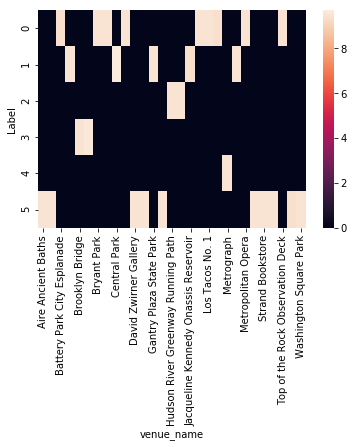

In [101]:
sns.heatmap(restaurant_col_plot)

D:\Work\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


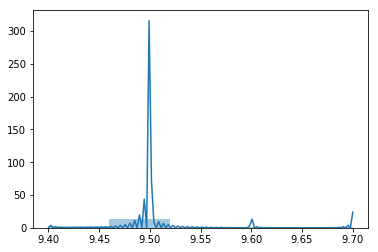

In [102]:
restaurant_col_dist = restaurant_col.groupby('venue_name')[['venue_score']].mean()
sns.distplot(restaurant_col_dist)

### Step 3: Create the folium map <a name = "map"></a>

In [6]:
from matplotlib import cm
from matplotlib import colors
import folium

In [104]:
keys = restaurant_type_on_map.columns.values.tolist()
i1 = restaurant_col.set_index(keys).index
i2 = restaurant_type_on_map.set_index(keys).index
restaurant_col_condensed = restaurant_col[i1.isin(i2)]
restaurant_col_condensed.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng,Label,color_index
0,412d2800f964a520df0c1fe3,American Wing Cafe,Café,40.780246,-73.963507,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,1,84
1,412d2800f964a520df0c1fe3,Bluestone Lane,Café,40.783757,-73.958526,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,1,84
2,412d2800f964a520df0c1fe3,Cafe Fledermaus,Café,40.781256,-73.960358,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,1,84
3,412d2800f964a520df0c1fe3,The Petrie Court Cafe & Wine Bar,Café,40.779160,-73.964408,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,1,84
4,412d2800f964a520df0c1fe3,Cafe 3,Café,40.783157,-73.958845,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,1,84


In [105]:
n_rainbow_venue = restaurant_pivot.Label.max() + 1
color_array_venue = cm.rainbow(np.linspace(0, 1, n_rainbow_venue))
color_venue = [colors.rgb2hex(i) for i in color_array_venue]
n_rainbow_food = restaurant_col_condensed.color_index.max() + 1
color_array_food = cm.rainbow(np.linspace(0, 1, n_rainbow_food))
color_food = [colors.rgb2hex(i) for i in color_array_food]

In [113]:
def add_marker(location_input, color_map, marker_size, food_map):
    for lat, lng, color_index, name in zip(location_input.iloc[:, 0], location_input.iloc[:, 1], 
                                           location_input.iloc[:, 2], location_input.iloc[:, 3]):
        pop_up = folium.Popup(name, parse_html = True)
        folium.CircleMarker(location = [lat, lng], radius = marker_size, popup = pop_up,
                            color = color_map[color_index], fill = True, fill_color = color_map[color_index], 
                            fill_opacity = 0.7).add_to(food_map)


In [12]:
map_food = folium.Map(location = [40.780246, -73.963507], zoon_start = 11)
folium.CircleMarker(
        [40.780246, -73.963507], radius = 5,
        color = '#FFFF00', fill = True, fill_color = '#FFFF00',
        fill_opacity = 0.7).add_to(map_food)
map_food

In [116]:
map_food = folium.Map(location = [map_lat, map_lng], zoon_start = 11)
#food_input = restaurant_col_condensed[['food_lat', 'food_lng', 'color_index', 'food_cat']]
#venue_input = restaurant_col_condensed[['venue_lat', 'venue_lng', 'Label', 'venue_name']].drop_duplicates()

#add_marker(food_input, color_food, 2, map_food)
#add_marker(venue_input, color_venue, 4, map_food)
#food_input


,food_lat,food_lng,color_index,food_cat
0,40.780246,-73.963507,84,Café
1,40.783757,-73.958526,84,Café
2,40.781256,-73.960358,84,Café
3,40.779160,-73.964408,84,Café
4,40.783157,-73.958845,84,Café
10,40.746826,-73.956399,84,Café
11,40.743732,-73.957790,84,Café
12,40.742568,-73.953835,84,Café
13,40.742339,-73.955342,84,Café
14,40.780246,-73.963507,84,Café
